#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 13
**CH11 Used cars**

using the used-cars dataset

version 0.8 2021-07-15

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse

warnings.filterwarnings("ignore")
# turning off scientific notation
#pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/used-cars/clean/"
data_out = dirname + "da_case_studies/ch13-used-cars-reg/"
output = dirname + "da_case_studies/ch13-used-cars-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# DATA IMPORT
data = pd.read_csv("/workspaces/codespaces-jupyter/data/used-cars_2cities_prep.csv")




In [4]:
# SAMPLE DESIGN

# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["condition"] = data["condition"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")


In [5]:
# drop hybrid models then drop column
data = data.loc[data.Hybrid == 0].drop(["Hybrid"], axis=1)


In [6]:
# check frequency by fuel type
freq = data.groupby("fuel").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
fuel,,,
Missing,1,0.190,0.190
diesel,1,0.190,0.380
gas,516,98.099,98.479
hybrid,1,0.190,98.669
other,7,1.331,100.000


In [7]:
# keep gas-fuelled vehicles
data = data.loc[data.fuel == "gas"]


In [8]:
# check frequency by vehicle condition
freq = data.groupby("condition").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
condition,,,
Missing,207,40.116,40.116
excellent,133,25.775,65.891
fair,14,2.713,68.604
good,106,20.543,89.147
like new,53,10.271,99.418
new,3,0.581,99.999


In [9]:
data

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,Missing,Missing,fwd,gas,1.315200,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
5,$1300,chicago,chicago city,1998 toyota camry,fair,4 cylinders,fwd,gas,16.824259,grey,...,Missing,0,1300,7.170120,1998,20,2.822822,0,0,0
6,$1600,chicago,chicago city,1998 toyota camry le,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,$1,los angeles,North LA county,2004 toyota camry,like new,Missing,Missing,gas,11.300000,NaN,...,Missing,0,1,0.000000,2004,14,2.424803,0,0,0
545,$6800,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,Missing,0,6800,8.824677,2012,6,2.116855,0,0,1
546,$2000,los angeles,central LA,2008 TOYOTA CAMRY,Missing,Missing,Missing,gas,12.548112,NaN,...,Missing,0,2000,7.600903,2008,10,2.529570,0,0,0
547,$2700,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,Missing,0,2700,7.901007,2002,16,2.778819,0,0,0


In [9]:
# drop vehicles in fair and new condition, trucks
data = data.loc[~data.condition.isin(["new", "fair"])]

# drop unrealistic values for price and odometer reading
data = data.loc[(data.price >= 500) & (data.price <= 25000) & (data.odometer <= 100)]

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.loc[
    ~((data.price < 1000) & ((data.condition == "like new") | (data.age < 8)))
]


In [10]:
data

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,type,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,Missing,gas,3.572100,NaN,...,sedan,1,14850,9.605755,2015,3,1.273154,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,Missing,Missing,fwd,gas,1.315200,NaN,...,sedan,1,15630,9.656947,2016,2,0.273989,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.700000,red,...,sedan,0,850,6.745236,1993,25,2.928523,0,0,0
6,$1600,chicago,chicago city,1998 toyota camry le,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1600,7.377759,1998,20,2.822822,1,0,0
7,$1500,chicago,chicago city,1998 Toyota Camry,Missing,Missing,Missing,gas,16.824259,NaN,...,Missing,0,1500,7.313220,1998,20,2.822822,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,$1500,los angeles,North LA county,2001 toyota camry,excellent,6 cylinders,Missing,gas,27.000000,NaN,...,Missing,0,1500,7.313220,2001,17,3.295837,0,0,0
545,$6800,los angeles,central LA,2012 toyota camry se,excellent,4 cylinders,Missing,gas,8.304974,NaN,...,Missing,0,6800,8.824677,2012,6,2.116855,0,0,1
546,$2000,los angeles,central LA,2008 TOYOTA CAMRY,Missing,Missing,Missing,gas,12.548112,NaN,...,Missing,0,2000,7.600903,2008,10,2.529570,0,0,0
547,$2700,los angeles,San Fernando,2002 toyota camry,excellent,4 cylinders,Missing,gas,16.100000,NaN,...,Missing,0,2700,7.901007,2002,16,2.778819,0,0,0


In [12]:
# check frequency by transmission
freq = data.groupby("transmission").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
transmission,,,
automatic,478,98.557,98.557
manual,7,1.443,100.000


In [13]:
data = data.loc[~(data.transmission == "manual")]


In [14]:
# check frequency by transmission
freq = data.groupby("type").agg(frequency=("type", "size"))
freq["percent"] = round(freq["frequency"] / sum(freq["frequency"]) * 100, 3)
freq["cumulative_percent"] = np.cumsum(freq["percent"])
freq


,frequency,percent,cumulative_percent
type,,,
Missing,223,46.653,46.653
SUV,1,0.209,46.862
convertible,6,1.255,48.117
coupe,19,3.975,52.092
pickup,1,0.209,52.301
sedan,227,47.490,99.791
wagon,1,0.209,100.000


In [11]:
# drop if truck
data = data.loc[~(data.type == "truck")]
# drop pricestr
data = data.drop(["pricestr"], axis=1)


In [12]:
# DATA GENERATION & DESCRIPTIVES
# CONDITION
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 2


In [13]:
# Frequency tables

# area
data.groupby("area").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
area,,
chicago,282,6049.411348
los angeles,203,5465.251232


In [14]:
# focus only on Chicago
data = data.loc[data.area == "chicago"]


In [15]:
# condition
data.groupby("condition").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
condition,,
Missing,124,6611.161290
excellent,75,6724.186667
good,68,3970.705882
like new,15,7455.200000


In [16]:
# drive
data.groupby("drive").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
drive,,
4wd,4,10168.750000
Missing,106,4575.094340
fwd,170,6869.405882
rwd,2,6250.000000


In [17]:
# dealer
data.groupby("dealer").agg(frequency=("price", "size"), mean=("price", np.mean))


,frequency,mean
dealer,,
0,194,4393.922680
1,88,9699.011364


In [18]:
# data summary
data.loc[
    :,
    [
        "age",
        "odometer",
        "LE",
        "XLE",
        "SE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "cylind6",
    ],
].describe()


,age,odometer,LE,XLE,SE,cond_likenew,cond_excellent,cond_good,cylind6
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,12.319149,12.552511,0.191489,0.070922,0.063830,0.053191,0.265957,0.241135,0.148936
std,5.891449,5.189217,0.394173,0.257151,0.244884,0.224814,0.442627,0.428532,0.356658
min,1.000000,0.231900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,8.212600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,13.727950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,16.445272,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,27.000000,25.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
# Histograms not in the textbook


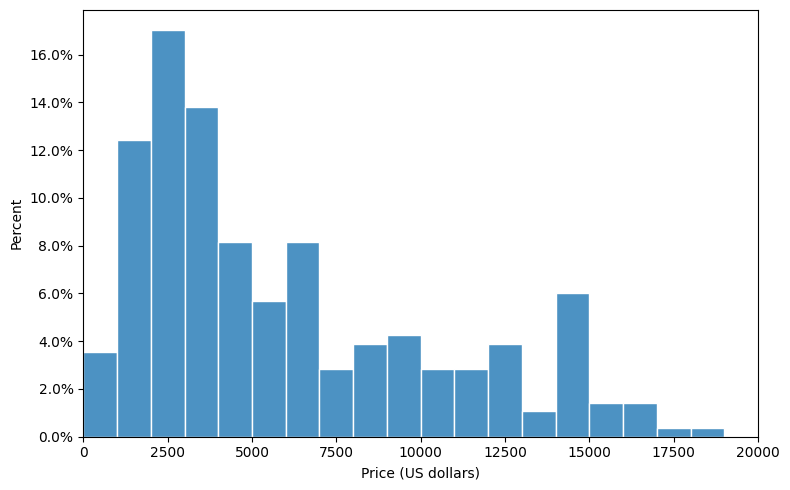

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8, 5))
sns.histplot(
    data["price"],
    bins=20,
    binrange=(0, 20000),
    color="tab:blue",  
    stat="probability",
    edgecolor="white",
    alpha=0.8
)
plt.xlim(0, 20000)
plt.xlabel("Price (US dollars)")
plt.ylabel("Percent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(range(0, 20001, 2500))
plt.grid(False)
plt.tight_layout()
plt.show()


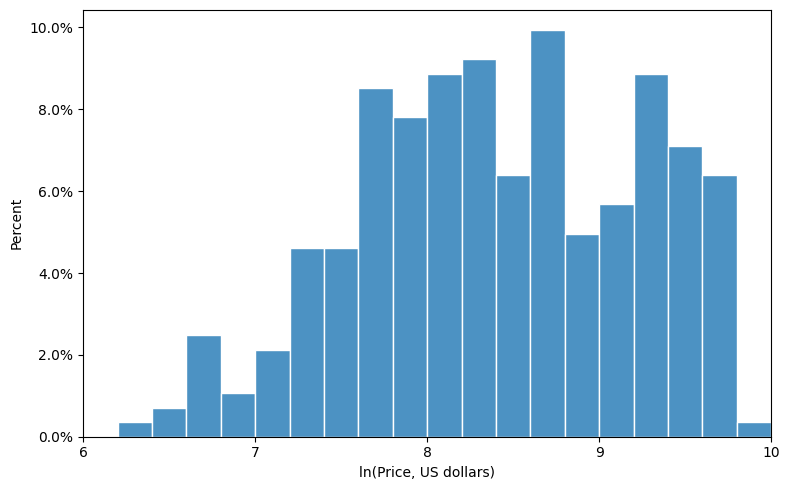

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data["lnprice"],
    bins=20,
    binrange=(6, 10),
    color="tab:blue",  
    stat="probability",
    edgecolor="white",
    alpha=0.8
)
plt.xlim(6, 10)
plt.xlabel("ln(Price, US dollars)")
plt.ylabel("Percent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(range(6, 11))
plt.grid(False)
plt.tight_layout()
plt.show()



### Regression analysis

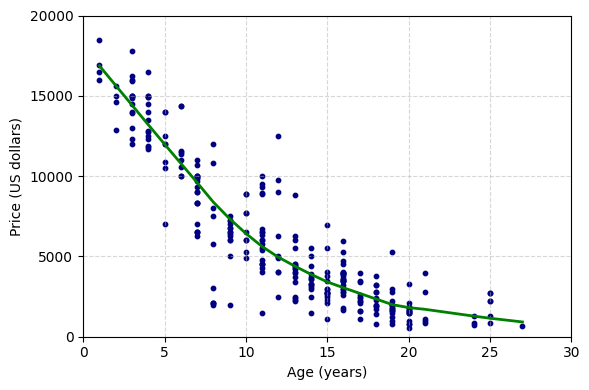

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for predicted probability
ax.scatter(data["age"], data["price"], s=10, color="navy", label="Predicted probability")

# LOWESS smoothing line
# Increase precision by lowering the 'frac' parameter (e.g., frac=0.5)
lowess_smoothed = lowess(data["price"], data["age"], frac=0.5)
ax.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="green", linewidth=2, label="LOWESS (frac=0.3)")

plt.xlabel("Age (years)")
plt.ylabel("Price (US dollars)")
plt.xlim(0, 30)
plt.ylim(0, 20000)
plt.xticks(range(0, 31, 5))
plt.yticks(range(0, 20001, 5000))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [38]:
data.describe()


,odometer,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,cond_excellent,cond_good,cond_likenew,cylind6,agesq,agecu,odometersq
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,12.552511,0.312057,6049.411348,8.409283,2005.680851,12.319149,2.401756,0.191489,0.070922,0.063830,0.265957,0.241135,0.053191,0.148936,186.347518,3150.638298,184.398025
std,5.189217,0.464157,4487.024148,0.811863,5.891449,5.891449,0.590598,0.394173,0.257151,0.244884,0.442627,0.428532,0.224814,0.356658,150.535461,3502.221631,128.060147
min,0.231900,0.000000,550.000000,6.309918,1991.000000,1.000000,-1.461449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.053778
25%,8.212600,0.000000,2500.000000,7.824046,2001.000000,7.000000,2.105554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,343.000000,67.462611
50%,13.727950,0.000000,4400.000000,8.389359,2005.000000,13.000000,2.619420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,2197.000000,188.461802
75%,16.445272,1.000000,8991.250000,9.104007,2011.000000,17.000000,2.800038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,289.000000,4913.000000,270.447061
max,25.300000,1.000000,18495.000000,9.825255,2017.000000,27.000000,3.230804,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,729.000000,19683.000000,640.090000


In [41]:
data.columns

Index(['area', 'subarea', 'name', 'condition', 'cylinders', 'drive', 'fuel',
       'odometer', 'paintcolor', 'size', 'transmission', 'type', 'dealer',
       'price', 'lnprice', 'year', 'age', 'lnodometer', 'LE', 'XLE', 'SE',
       'cond_excellent', 'cond_good', 'cond_likenew', 'cylind6', 'agesq',
       'agecu', 'odometersq'],
      dtype='object')

## Linear regressions

In [39]:
# Model 1: Linear regression on age
model1 = "price ~ age + agesq"

# Models 2-5: Multiple linear regressions
# note: condition - missing will be baseline for regs
model2 = "price ~ age + agesq + odometer"
model3 = "price ~ age + agesq + odometer + odometersq + LE + cond_excellent + cond_good + dealer"
model4 = "price ~ age + agesq + odometer + odometersq + LE + XLE + SE + cond_likenew + cond_excellent + cond_good + cylind6 + dealer"
model5 = "price ~ age + agesq + odometer + odometersq + LE * age + XLE * age + SE * age + cond_likenew * age + cond_excellent * age + cond_good * age + cylind6 * age + odometer * age + dealer * age"

model_equations = [model1, model2, model3, model4, model5]

Estimate regressions

In [28]:
regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data).fit(cov_type="HC1"))

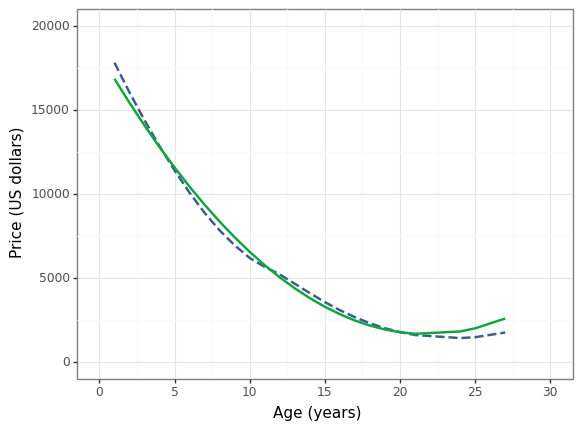

<ggplot: (378047395)>

In [29]:
(
    ggplot(data, aes(x="age"))
    + geom_smooth(
        aes(y="price"),
        colour=color[0],
        linetype="dashed",
        method="loess",
        se=False,
        size=1,
    )
    + geom_line(aes(y="regs[0].predict()"), colour=color[1], size=1)
    + labs(x="Age (years)", y="Price (US dollars)")
    + theme_bw()
    + scale_x_continuous(limits=(0, 30), breaks=seq(0, 30, 5))
    + scale_y_continuous(limits=(0, 20000), breaks=seq(0, 20000, 5000))
)

### Table 13.2 Regression models for predicting used car price

In [30]:
stargazer.Stargazer(regs[:4])


Model 5 - not displayed in book

In [31]:
regs[4].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     201.9
Date:                Mon, 10 Oct 2022   Prob (F-statistic):          2.33e-147
Time:                        12:09:21   Log-Likelihood:                -2400.5
No. Observations:                 281   AIC:                             4845.
Df Residuals:                     259   BIC:                             4925.
Df Model:                          21                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.848e+04    767.723     24.066      0.000     1.7e+04       2e+04
age                 -800.5516     97.208     -8.235      0.000    -991.076    -610.027
agesq                 11.2105      3.463      3.238      0.001       4.424      17.997
odometer            -783.8117     77.321    -10.137      0.000    -935.358    -632.265
odometersq            13.0986      3.591      3.647      0.000       6.060      20.137
LE                  1002.5851    818.037      1.226      0.220    -600.738    2605.908
LE:age               -72.0799     49.394     -1.459      0.144    -168.891      24.731
XLE                  863.7939    936.233      0.923      0.356    -971.190    2698.777
XLE:age              -44.2100     59.971     -0.737      0.461    -161.752      73.332
SE                   912.1881   1113.534      0.819      0.413   -1270.299    3094.675
SE:age                57.6355     92.210      0.625      0.532    -123.092     238.363
cond_likenew        1390.9522    974.268      1.428      0.153    -518.577    3300.482
cond_likenew:age     -69.2110     65.402     -1.058      0.290    -197.397      58.975
cond_excellent       277.1115    531.308      0.522      0.602    -764.233    1318.456
cond_excellent:age    -1.7016     35.789     -0.048      0.962     -71.847      68.444
cond_good            912.5754    804.010      1.135      0.256    -663.255    2488.406
cond_good:age        -44.1931     44.904     -0.984      0.325    -132.204      43.817
cylind6            -1609.8891   1092.487     -1.474      0.141   -3751.125     531.347
cylind6:age           87.2012     62.512      1.395      0.163     -35.319     209.722
odometer:age          12.5010      5.690      2.197      0.028       1.349      23.653
dealer              1360.7111    638.848      2.130      0.033     108.592    2612.830
dealer:age           -39.5013     42.473     -0.930      0.352    -122.746      43.744
==============================================================================
Omnibus:                       21.996   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.209
Skew:                           0.353   Prob(JB):                     7.59e-12
Kurtosis:                       4.969   Cond. No.                     5.75e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 5.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Cross validation

Use custom function `ols_crossvalidator` for cross validation

In [32]:
help(ols_crossvalidator)

Help on function ols_crossvalidator in module py_helper_functions:

ols_crossvalidator(formula: str, data: pandas.core.frame.DataFrame, n_folds=5, average_rmse=True) -> dict
    OLS cross-validator
    
    
    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.
    
    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.



Set n_fold = 4 for 4-fold cross-validation

In [33]:
n_fold = 4

Cross-validate models

In [34]:
cv_list = []
for equation in model_equations:
    cv_list.append(ols_crossvalidator(equation, data, n_fold, average_rmse=False))

### Table 13.4 Car price models estimated using all original data and measures of fit using all original data

In [35]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"].astype(int),
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[1, 2, 5, 6, 6],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,1,3,0.85,1755,5012
Model 2,2,4,0.90,1433,4904
Model 3,5,9,0.91,1322,4887
Model 4,6,13,0.92,1273,4888
Model 5,6,22,0.92,1241,4925


### Table 13.5 Car price models estimated and evaluated using 4-fold cross-validation and RMSE

In [36]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round().astype(int)

,Model 1,Model 2,Model 3,Model 4,Model 5
Fold1,2184,1685,1517,1546,1496
Fold2,1591,1435,1333,1335,1410
Fold3,1925,1538,1476,1424,1495
Fold4,1541,1428,1429,1372,1438
Average,1810,1521,1439,1419,1460


### Prediction

In [37]:
data = data.loc[
    :,
    [
        "age",
        "agesq",
        "odometer",
        "odometersq",
        "SE",
        "LE",
        "XLE",
        "cond_likenew",
        "cond_excellent",
        "cond_good",
        "dealer",
        "price",
        "cylind6",
    ],
]


In [38]:
data.dtypes


age                 int64
agesq               int64
odometer          float64
odometersq        float64
SE                  int64
LE                  int64
XLE                 int64
cond_likenew        int64
cond_excellent      int64
cond_good           int64
dealer              int64
price               int64
cylind6             int64
dtype: object

In [39]:
new = pd.DataFrame(
    pd.Series(
        {
            "age": 10,
            "agesq": 10**2,
            "odometer": 12,
            "odometersq": 12**2,
            "SE": 0,
            "LE": 1,
            "XLE": 0,
            "cond_likenew": 0,
            "cond_excellent": 1,
            "cond_good": 0,
            "dealer": 0,
            "price": np.nan,
            "cylind6": 0,
        }
    )
).T
new


,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [40]:
new.append(new)

,age,agesq,odometer,odometersq,SE,LE,XLE,cond_likenew,cond_excellent,cond_good,dealer,price,cylind6
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
0,10.0,100.0,12.0,144.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0


In [41]:
reg1 = regs[0]
reg3 = regs[2]

In [42]:
reg1.resid.describe()


count    2.810000e+02
mean     8.544719e-12
std      1.758313e+03
min     -6.367827e+03
25%     -8.636628e+02
50%     -1.013318e+02
75%      8.936205e+02
max      7.448668e+03
dtype: float64

In [43]:
(reg3.fittedvalues - data.price).describe()


count    2.810000e+02
mean    -1.530281e-11
std      1.325029e+03
min     -5.782218e+03
25%     -5.845089e+02
50%      1.056349e+01
75%      6.282881e+02
max      4.245894e+03
dtype: float64

### Table 13.3 Point predictions and interval predictions for a specific car, using models 1 and 3

Use custom function `point_predict_with_conf_int` to extract point and interval prediction for a new datapoint.

In [44]:
help(point_predict_with_conf_int)

Help on function point_predict_with_conf_int in module py_helper_functions:

point_predict_with_conf_int(regression: statsmodels.regression.linear_model.RegressionResultsWrapper, new_datapoint: pandas.core.frame.DataFrame, interval_precision=0.95, round_n=2) -> dict
    Does point prediction and interval prediction for a new datapoint.
    
        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.



In [45]:
p95 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.95, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.95, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p95.loc["Prediction Interval (95%)", :] = p95.loc["Prediction Interval (95%)", :].apply(
    format_confidence_interval
)

In [46]:
p80 = pd.DataFrame(
    [
        point_predict_with_conf_int(reg1, new, interval_precision=0.8, round_n=0),
        point_predict_with_conf_int(reg3, new, interval_precision=0.8, round_n=0),
    ],
    index=["Model 1", "Model 2"],
).T
p80.loc["Prediction Interval (80%)", :] = p80.loc["Prediction Interval (80%)", :].apply(
    format_confidence_interval
)

In [47]:
p80.append(p95.loc["Prediction Interval (95%)"])

,Model 1,Model 2
Point prediction,6569,6073
Prediction Interval (80%),[4299–8840],[4323–7822]
Prediction Interval (95%),[3097–10042],[3397–8749]
